# Basic example to play with CUSUM (cumulative sum control chart)

<font color=red>**The red part is added by myself as a note of a training.**</font>

## Imports

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pdb
# %matplotlib

# Parameters

In [2]:
n1 = 100  # Time before the abrupt change
n2 = 100  # Time after the abrupt change

# Distribution parameters before the abrupt change (Normal law)
mu1 = 0
sigma1 = +0.5
# Distribution parameters after the abrupt change 
mu2 = 1
sigma2 = +0.5

# Detection threshold
gThr = 5

# Signal generation

In [3]:
vT = np.arange(0, n1+n2)
vY = np.concatenate((np.zeros(n1), np.ones(n2)), axis=0)
vX = np.concatenate((stats.norm.rvs(loc=mu1, scale=sigma1, size=n1),
                     stats.norm.rvs(loc=mu2, scale=sigma2, size=n2)), axis=0)

# Test

In [4]:
vG0 = np.zeros((vX.shape[0]+1))
vG1 = np.zeros((vX.shape[0]+1))
for idx in range(vX.shape[0]):
    vG1[idx+1] = vG1[idx]+np.log(stats.norm.pdf(vX[idx], loc=mu2, scale=sigma2)/
                                 stats.norm.pdf(vX[idx], loc=mu1, scale=sigma1))
    vG1[idx+1] = np.max([vG1[idx+1], 0])
    vG0[idx+1] = vG0[idx]+np.log(stats.norm.pdf(vX[idx], loc=mu2, scale=sigma2)/
                                 stats.norm.pdf(vX[idx], loc=mu1, scale=sigma1))
vG0 = vG0[1:]
vG1 = vG1[1:]

In [5]:
idFlag = np.argwhere(vG1>=gThr)[0]

## Illustrations

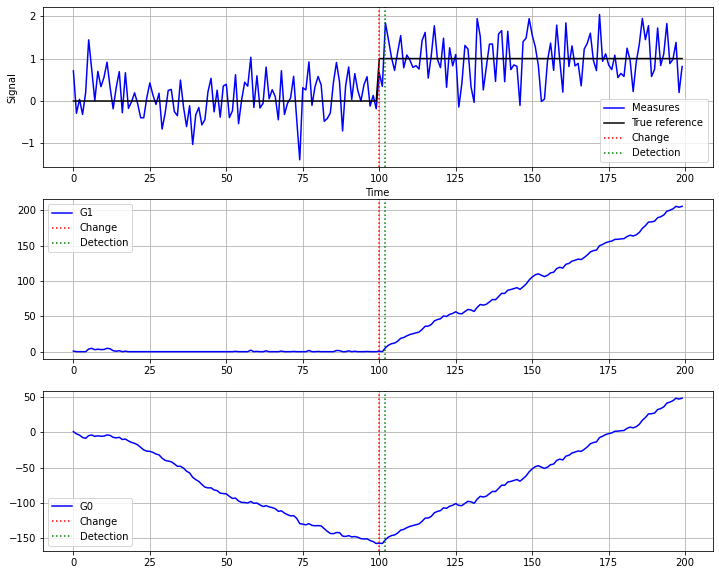

In [6]:

fig, ax = plt.subplots(3, 1, figsize=(12, 10))
# Signal
ax[0].plot(vT, vX, 'b', label='Measures')
ax[0].plot(vT, vY, 'k', label='True reference')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal')
ax[0].grid(True)
ylim = ax[0].get_ylim()
ax[0].plot([n1, n1], ylim, 'r:', label='Change')
ax[0].plot([vT[idFlag], vT[idFlag]], ylim, 'g:', label='Detection')
ax[0].set_ylim(ylim)
ax[0].legend()
# G1
ax[1].plot(vT, vG1, 'b', label='G1')
ax[1].grid(True)
ylim = ax[1].get_ylim()
ax[1].plot([n1, n1], ylim, 'r:', label='Change')
ax[1].plot([vT[idFlag], vT[idFlag]], ylim, 'g:', label='Detection')
ax[1].set_ylim(ylim)
ax[1].legend()
# G0
ax[2].plot(vT, vG0, 'b', label='G0')
ax[2].grid(True)
ylim = ax[2].get_ylim()
ax[2].plot([n1, n1], ylim, 'r:', label='Change')
ax[2].plot([vT[idFlag], vT[idFlag]], ylim, 'g:', label='Detection')
ax[2].set_ylim(ylim)
ax[2].legend()


<font color=red>**How to chooose the threshold?**    
Choose the threshold, and let's play a good number of examples(like m=200), and we see the number of false alarm and of non detection.
The following part is an operation of this and we will try to find a good threshold.</font> 

## Average behavior
<font color=red>We first process the same algo to our avaerage.</font> 

In [7]:
# Signals generations
m = 1000
vT = np.arange(0, n1+n2)
vY = np.concatenate((np.zeros(n1), np.ones(n2)), axis=0)
mX = np.concatenate((stats.norm.rvs(loc=mu1, scale=sigma1, size=(n1, m)),
                     stats.norm.rvs(loc=mu2, scale=sigma2, size=(n2, m))), axis=0)

In [8]:
# Test
mG1 = np.zeros((mX.shape[0]+1, m))
for idx in range(mX.shape[0]):
    mG1[idx+1, :] = mG1[idx, :]+np.log(stats.norm.pdf(mX[idx, :], loc=mu2, scale=sigma2)/
                                 stats.norm.pdf(mX[idx, :], loc=mu1, scale=sigma1))
    mG1[idx+1] = mG1[idx+1, :]*(mG1[idx+1]>0)
mG1 = mG1[1:, :]

(-13.023342686725497, 273.4901964212354)

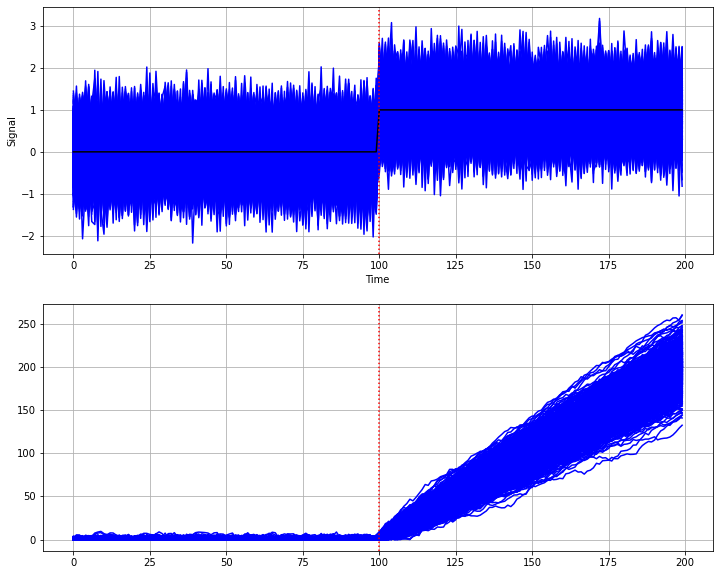

In [9]:
# Illustrations
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
# Signal
for idm in range(m):
    ax[0].plot(vT, mX[:, idm], 'b', label='Measures')
ax[0].plot(vT, vY, 'k', label='True reference')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal')
ax[0].grid(True)
ylim = ax[0].get_ylim()
ax[0].plot([n1, n1], ylim, 'r:', label='Change')
ax[0].set_ylim(ylim)
# G1
for idm in range(m):
    ax[1].plot(vT, mG1[:, idm], 'b', label='G1')
ax[1].grid(True)
ylim = ax[1].get_ylim()
ax[1].plot([n1, n1], ylim, 'r:', label='Change')
ax[1].set_ylim(ylim)

In [10]:
# Get detection
vFlag = np.zeros(m)
for idm in range(m):
    vFlag[idm] = np.argwhere(mG1[:, idm]>=gThr)[0]

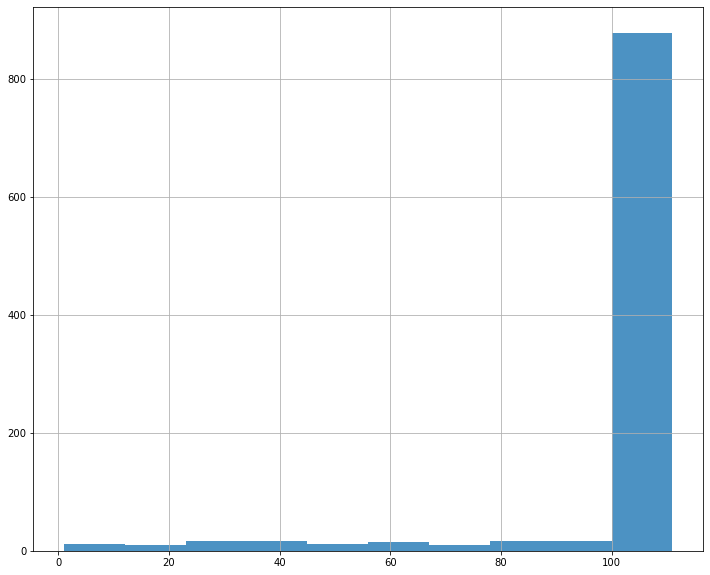

In [11]:
# Histogram
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.hist(vFlag, bins=10, alpha=0.8)
ax.grid(True)

## <font color=red>Choice of threshold</font>

In [12]:
false_alarm = np.zeros(25)
avaerage_good_delay = np.zeros(25)
for gThr in range(0,25):
    # Get detection
    vFlag = np.zeros(m)
    for idm in range(m):
        vFlag[idm] = np.argwhere(mG1[:, idm]>=gThr)[0]
    total_delay = 0
    for i in range(m):
        false_alarm[gThr] += (vFlag[i]<n1)
        total_delay += max(vFlag[i]-n1,0)
    avaerage_good_delay[gThr] = total_delay / max(m - false_alarm[gThr],1)

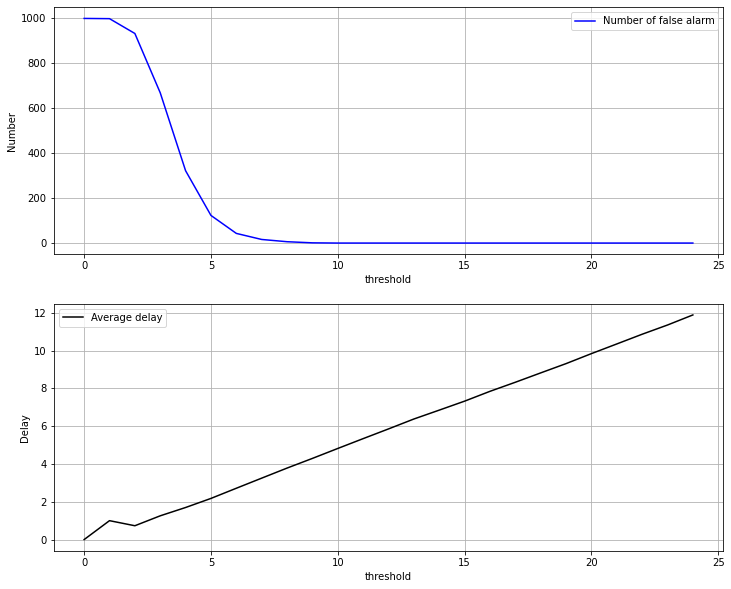

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
# Signal
ax[0].plot(range(25), false_alarm, 'b', label='Number of false alarm')
ax[1].plot(range(25), avaerage_good_delay, 'k', label='Average delay')
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('Number')
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('Delay')
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend()
ax[1].legend()